In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

from joblib import Parallel, delayed

sys.path.append('../utilities')
from utilities2015 import *
from clustering import *

%matplotlib inline

In [2]:
# surround_high_contrast_thresh = .1
coherence_limit = .25
# significance_limit = .8
area_limit = 60000
nonoverlapping_area_limit = 2.
bg_texton = 3
bg_texton_percentage = .2
# significance_limit = -0.81
significance_limit = 0.05
consensus_limit = -20

In [3]:
dm = DataManager(stack='MD594', section=100, segm_params_id='tSLIC200')
# dm._load_image(format='gray')

In [4]:
dm.load_multiple_results(results=['texHist', 'segmentation', 'texMap', 'neighbors', 
                                  'edgeCoords', 'spCentroids', 'edgeNeighbors', 'dedgeNeighbors',
                                  'spCoords', 'edgeMidpoints', 'spAreas'])

In [5]:
all_seed_cluster_score_dedge_tuples = dm.load_pipeline_result('allSeedClusterScoreDedgeTuples')

In [6]:
all_seeds, all_clusters, all_cluster_scores, all_cluster_dedges = zip(*all_seed_cluster_score_dedge_tuples)

In [7]:
sys.stderr.write('%d proposals\n'%len(all_clusters))

7977 proposals


In [8]:
all_clusters_unique_dict = {}
for i, cl in enumerate(all_clusters):
    all_clusters_unique_dict[frozenset(cl)] = i

In [9]:
all_unique_cluster_indices = all_clusters_unique_dict.values()
all_unique_clusters = [all_clusters[i] for i in all_unique_cluster_indices]
all_unique_dedges = [all_cluster_dedges[i] for i in all_unique_cluster_indices]

In [10]:
all_unique_cluster_scores = [all_cluster_scores[i] for i in all_unique_cluster_indices]
all_unique_seeds = [all_seeds[i] for i in all_unique_cluster_indices]

In [11]:
sys.stderr.write('%d unique proposals\n'%len(all_unique_clusters))

6257 unique proposals


In [12]:
def compute_cluster_coherence_score(cluster, verbose=False):
    
    if len(cluster) > 1:
        cluster_avg = dm.texton_hists[cluster].mean(axis=0)
        ds = np.squeeze(chi2s([cluster_avg], dm.texton_hists[list(cluster)]))
        var = ds.mean()
    else:
        var = 0
    
    return var

def compute_cluster_significance_score(*args, **kwargs):
    return dm.compute_cluster_score(*args, **kwargs)[0]

In [13]:
def compute_cluster_consensus_score(se, cl):
    diff_sizes = [np.min([len((set(cl2)|set(cl))-(set(cl2)&set(cl))) for cl2 in growed_from[s]]) 
                  for s in cl if s != se and len(growed_from[s]) > 0]
    if len(diff_sizes) > 0:
        mean_diff = np.mean(diff_sizes)
        return -mean_diff
    else:
        return -np.inf

In [14]:
growed_from = defaultdict(list)
for se, cl in zip(all_seeds, all_clusters):
    growed_from[se].append(cl)
    
all_cluster_consensus = Parallel(n_jobs=16)(delayed(compute_cluster_consensus_score)(se, cl) 
                                                for se, cl in zip(all_unique_seeds, all_unique_clusters))
all_cluster_consensus = np.array(all_cluster_consensus)

In [15]:
# all_cluster_sigs = np.array([compute_cluster_significance_score(cl, method='rc-mean') for cl in all_clusters])
all_cluster_sigs = np.array(all_unique_cluster_scores)
all_cluster_coherences = np.array([compute_cluster_coherence_score(cl) for cl in all_unique_clusters])

In [16]:
# all_cluster_sigs_perc = np.array(Parallel(n_jobs=16)(delayed(compute_cluster_significance_score)(cl, method='percentage-soft',
#                                 thresh=surround_high_contrast_thresh) for cl in all_unique_clusters))

# # all_cluster_sigs_perc = np.array([compute_cluster_significance_score(cl, method='percentage-soft',
# #                                                                thresh=surround_high_contrast_thresh) 
# #                              for cl in all_clusters])

In [17]:
all_cluster_hists = [dm.texton_hists[cl].mean(axis=0) for cl in all_unique_clusters]
all_cluster_entropy = np.nan_to_num([-np.sum(hist[hist!=0]*np.log(hist[hist!=0])) for hist in all_cluster_hists])

all_cluster_centroids = np.array([dm.sp_centroids[cl, ::-1].mean(axis=0) for cl in all_unique_clusters])

# all_cluster_compactness = np.array([len(eds)**2/float(len(cl)) for cl, eds in zip(all_unique_clusters, all_cluster_dedges)])
# all_cluster_compactness = .001 * np.maximum(all_cluster_compactness-40,0)**2

all_cluster_area = np.array([dm.sp_areas[cl].sum() for cl in all_unique_clusters])

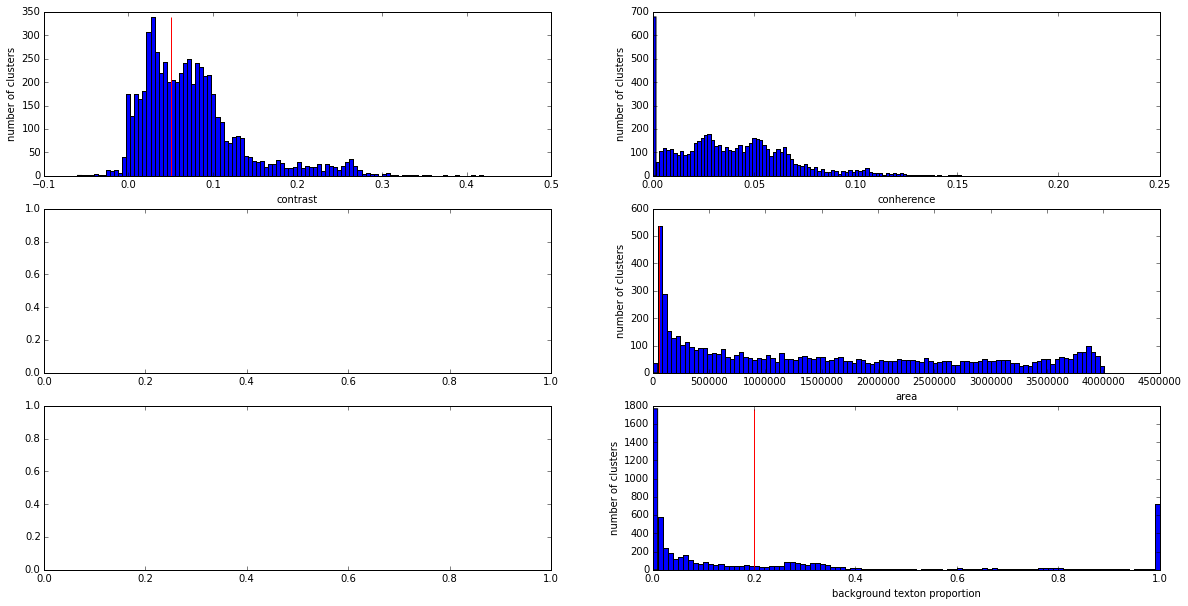

In [18]:
fig, axes = plt.subplots(3, 2, squeeze=True, figsize=(20,10))
axes = axes.flatten()

h = axes[0].hist(all_cluster_sigs, bins=100);
axes[0].set_xlabel('contrast');
axes[0].set_ylabel('number of clusters');
axes[0].vlines(significance_limit, 0, h[0].max(), color='r');

h = axes[1].hist(all_cluster_coherences, bins=100);
axes[1].set_xlabel('conherence');
axes[1].set_ylabel('number of clusters');
axes[1].vlines(coherence_limit, 0, h[0].max(), color='r');
# h = axes[2].hist(all_cluster_compactness, bins=100);
# axes[2].set_xlabel('compactness');
# axes[2].set_ylabel('number of clusters');
# axes[2].vlines(50, 0, h[0].max(), color='r');

h = axes[3].hist(all_cluster_area, bins=100);
axes[3].set_xlabel('area');
axes[3].set_ylabel('number of clusters');
axes[3].vlines(area_limit, 0, h[0].max(), color='r');

# h = axes[4].hist(all_cluster_consensus[all_cluster_consensus!=-np.inf], bins=100);
# axes[4].set_xlabel('consensus');
# axes[4].set_ylabel('number of clusters');
# axes[4].vlines(consensus_limit, 0, h[0].max(), color='r');

h = axes[5].hist([hist[bg_texton] for hist in all_cluster_hists], bins=100);
axes[5].set_xlabel('background texton proportion');
axes[5].set_ylabel('number of clusters');
axes[5].vlines(bg_texton_percentage, 0, h[0].max(), color='r');

In [19]:
remaining_cluster_indices = [i for i, (cl, coh, sig, ent, cent, area, cons, hist) in enumerate(zip(all_unique_clusters, 
                                                                                      all_cluster_coherences, 
                                                                                      all_cluster_sigs,
#                                                                                     all_cluster_sigs_perc,
                                                                                      all_cluster_entropy,
                                                                                      all_cluster_centroids,
#                                                                                       all_cluster_compactness,
                                                                                      all_cluster_area,
                                                                                    all_cluster_consensus,
                                                                                    all_cluster_hists)) 
            if coh < coherence_limit and sig > significance_limit and \
                area > area_limit and cons > consensus_limit and \
#                  comp < 50 and \
             ((ent > 1.5 and hist[bg_texton] < bg_texton_percentage) or \
              (cent[0] - dm.xmin > 800 and \
               dm.xmax - cent[0] > 800 and \
               cent[1] - dm.ymin > 800 and \
               dm.ymax - cent[1] > 800)
             )]

In [20]:
sys.stderr.write('remaining_cluster_indices = %d\n'%len(remaining_cluster_indices))

remaining_cluster_indices = 1208


In [21]:
all_remaining_seeds = [all_unique_seeds[i] for i in remaining_cluster_indices]
all_remaining_clusters = [all_unique_clusters[i] for i in remaining_cluster_indices]
all_remaining_cluster_dedges = [all_unique_dedges[i] for i in remaining_cluster_indices]
all_remaining_cluster_sigs = [all_cluster_sigs[i] for i in remaining_cluster_indices]
all_remaining_cluster_hists = [all_cluster_hists[i] for i in remaining_cluster_indices]

In [22]:
# nonoverlapping_area_limit = 3

In [23]:
all_remaining_overlap_mat = compute_pairwise_distances(all_remaining_clusters, metric='overlap-size')

In [24]:
# all_remaining_da_mat = compute_pairwise_distances(all_remaining_clusters, metric='nonoverlap-area', 
#                                                       sp_areas=dm.sp_areas)

In [25]:
all_remaining_histdist_mat = compute_pairwise_distances(all_remaining_cluster_hists, chi2)

In [26]:
# all_remaining_hist_distmat = pdist(all_remaining_cluster_hists, chi2)
# all_remaining_hist_distmat = squareform(all_remaining_hist_distmat)

In [27]:
# all_remaining_distmat = (all_remaining_da_distmat > nonoverlapping_area_limit) | (all_remaining_hist_distmat > .2)
all_remaining_distmat = ~((all_remaining_overlap_mat > 0) & (all_remaining_histdist_mat < .2))

In [28]:
t = time.time()

all_remaining_cluster_tuples = zip(all_remaining_seeds, all_remaining_clusters, all_remaining_cluster_dedges,
                                   all_remaining_cluster_hists, all_remaining_cluster_sigs)

cluster_indices_grouped, tuples_grouped, _ = group_tuples(all_remaining_cluster_tuples, 
                                                        val_ind = 1,
                                                        distance_matrix=all_remaining_distmat,
                                                       dist_thresh=.00001,
                                                       linkage='complete')

print time.time() - t

0.469274044037


In [37]:
n_group = len(cluster_indices_grouped)
sys.stderr.write('%d groups\n'%n_group)

173 groups


In [38]:
group_internal_order = [np.argsort(map(itemgetter(4), tuple_group))[::-1] for tuple_group in tuples_grouped]
cluster_indices_grouped = [[ci_group[i] for i in order] for order, ci_group in zip(group_internal_order, cluster_indices_grouped)]
tuples_grouped = [[tuple_group[i] for i in order] for order, tuple_group in zip(group_internal_order, tuples_grouped)]

In [39]:
all_seeds_grouped, all_clusters_grouped, all_dedges_grouped, \
all_hists_grouped, all_sigs_grouped = [list(map(list, lst)) for lst in zip(*[zip(*g) for g in tuples_grouped])]

In [29]:
reps = [g[0] for g in cluster_indices_grouped]

In [30]:
all_reps_overlap_mat = compute_pairwise_distances([all_remaining_clusters[i] for i in reps], 
                                                       metric='overlap-size')
all_reps_histdist_mat = compute_pairwise_distances([all_remaining_cluster_hists[i] for i in reps], chi2)

In [31]:
all_reps_distmat = ~((all_reps_overlap_mat > 0) & (all_reps_histdist_mat < .1))

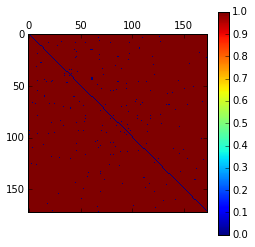

In [32]:
plt.matshow(all_reps_distmat);
plt.colorbar();

In [33]:
_, repind_clusters_grouped, _ = group_tuples([(i, all_remaining_clusters[i]) for i in reps], 
                                              val_ind = 1, distance_matrix=all_reps_distmat,
                                              dist_thresh=.00001, linkage='single')

In [34]:
reps_grouped = [map(itemgetter(0), grp) for grp in repind_clusters_grouped]
clusters_grouped = [map(itemgetter(1), grp) for grp in repind_clusters_grouped]

In [35]:
sys.stderr.write('%d nonoverlapping groups\n' % len(clusters_grouped))

89 nonoverlapping groups


In [ ]:
def visu(i, cl_grp):
    dm.visualize_clusters_in_subplots(cl_grp, fname='group%02d.jpg'%i,
                                     titles=['%.3f'%all_remaining_cluster_sigs[rep] for rep in reps_grouped[i]])

In [ ]:
_ = Parallel(n_jobs=16)(delayed(visu)(i, cl_grp) for i, cl_grp in enumerate(clusters_grouped))

In [ ]:
# for i, cl_grp in enumerate(clusters_grouped):
#     print i
#     dm.visualize_clusters_in_subplots(cl_grp, fname='group%02d.jpg'%i)

In [ ]:
# all_scores_grouped = [[compute_cluster_significance_score(g, method='percentage') for g in cg] 
#                           for cg in all_clusters_grouped]

# all_cluster_grouped_union = [set.union(*map(set, cls)) for cls in all_clusters_grouped]
# # all_cluster_grouped_union = [smart_union(cls) for cls in all_clusters_grouped]
# # all_scores_grouped = np.array([len(seeds) / float(len(union_cl)) for seeds, union_cl in zip(all_seeds_grouped,
# #                                                                                   all_cluster_grouped_union)])
# all_scores_grouped = np.array([-dm.sp_areas[list(set(union_cl)-set(seeds))].sum()
#                                for seeds, union_cl in zip(all_seeds_grouped, all_cluster_grouped_union)])

In [40]:
group_rep_indices = map(np.argmax, all_sigs_grouped)

group_rep_clusters = [cls[rep] for cls, rep in zip(all_clusters_grouped, group_rep_indices)]

group_contrasts = [compute_cluster_significance_score(cl, method='rc-mean') for cl in group_rep_clusters]

group_size = [len(g) for g in all_clusters_grouped]

def scores_to_vote(scores):
    vals = np.unique(scores)
    d = dict(zip(vals, np.linspace(0, 1, len(vals))))
    votes = np.array([d[s] for s in scores])
    votes = votes/votes.sum()
    return votes

d1 = scores_to_vote(group_contrasts)
d3 = scores_to_vote(group_size)
group_indices_ranked = np.argsort(.5*d1 + 0*d3)[::-1]

rep_sigs_ranked = [group_contrasts[i] for i in group_indices_ranked]
rep_clusters_ranked = [all_clusters_grouped[i][group_rep_indices[i]] for i in group_indices_ranked]
rep_dedges_ranked = [dm.find_boundary_dedges_ordered(cl) for cl in rep_clusters_ranked]

# good_clusters = rep_clusters_ranked
# good_dedges = rep_dedges_ranked

In [41]:
dm.save_pipeline_result(zip(rep_clusters_ranked, rep_dedges_ranked, rep_sigs_ranked), 'proposals')

saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD594/0100/MD594_0100_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_proposals.pkl


In [ ]:
[(rank, group_contrasts[i], len(all_clusters_grouped[i]), i) for rank, i in enumerate(group_indices_ranked)]

In [ ]:
research_sp = 961

gs_all = [gi for gi, cl in enumerate(all_remaining_clusters) if research_sp in cl]
print gs_all


In [ ]:
gs = [(gi, [remaining_cluster_indices[i] for i in inds]) 
      for gi, (cls, inds) in enumerate(zip(all_clusters_grouped, cluster_indices_grouped)) if any(research_sp in cl
      for cl in cls)]

print gs
print 'group id / group size / rank'
for x in sorted([(i, len(all_clusters_grouped[i]), group_indices_ranked.tolist().index(i) )
                     for i, inds in gs], key=itemgetter(2)):
    print x

In [ ]:
gi = 21
dm.visualize_clusters_in_subplots(all_clusters_grouped[gi], 
                                  titles=['lr %.3f, %d'%(all_remaining_cluster_sigs[i], i)
                                          for i in cluster_indices_grouped[gi]])

In [ ]:
for i in range(0, min(100, len(good_dedges)), 10):
    viz = dm.visualize_edge_sets(good_dedges[i:i+10], show_set_index=True)
    try:
        dm.save_pipeline_result(viz, 'landmarks%dViz'%(i+10))
    except:
        pass

In [42]:
sp_covered_by = defaultdict(set)
for i, cl in enumerate(rep_clusters_ranked):
    for s in cl:
        sp_covered_by[s].add(i)

In [43]:
dm.save_pipeline_result(sp_covered_by, 'spCoveredByProposals')

saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD594/0100/MD594_0100_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_spCoveredByProposals.pkl


In [32]:
def fit_ellipse_to_points(pts):

    pts = np.array(list(pts) if isinstance(pts, set) else pts)

    c0 = pts.mean(axis=0)

    coords0 = pts - c0

    U,S,V = np.linalg.svd(np.dot(coords0.T, coords0)/coords0.shape[0])
    v1 = U[:,0]
    v2 = U[:,1]
    s1 = np.sqrt(S[0])
    s2 = np.sqrt(S[1])

    return v1, v2, s1, s2, c0

In [33]:
boundary_models = []

for i, (cl, dedges, sig) in enumerate(zip(rep_clusters_ranked, rep_dedges_ranked, rep_sigs_ranked)[:100]):

    dedge_list = list(dedges)

    interior_texture = dm.texton_hists[list(cl)].mean(axis=0)
    exterior_textures = []
    
    cluster_coords = np.vstack([dm.sp_coords[s] for s in cl])
    ell = fit_ellipse_to_points(cluster_coords)
    
    edge_points = []
    
    for e in dedge_list:
        pts_e = dm.edge_coords[frozenset(e)]
        sample_indices = np.arange(20, len(pts_e)-20, 200)

        if len(sample_indices) > 0:
            sample_pts_e = pts_e[sample_indices]
            edge_points.append(sample_pts_e)
            surr = e[0]
            ext_tex = dm.texton_hists[surr] if surr != -1 else np.nan * np.ones((dm.n_texton,))
            exterior_textures.append([ext_tex for _ in sample_indices])
    
    edge_points = np.vstack(edge_points)
    exterior_textures = np.vstack(exterior_textures)

    center = np.mean([dm.edge_midpoints[frozenset(e)] for e in dedge_list], axis=0)

    boundary_models.append((cl, dedge_list, sig, interior_texture, exterior_textures, edge_points, center) +\
                           ell)


In [34]:
dm.save_pipeline_result(boundary_models, 'boundaryModels')

saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0060/MD593_0060_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_boundaryModels.pkl
